# Prediction Model for Salary
## Author: Xiaochi (George) Li

Input: "processed_data.pickle" from the preprocessing part  
Spec: No missing value, target variable "salary" should be the last column

Reference: Python Machine Learning (PyML) 2nd Sebastian Raschka

### Summary
In this part, we took the preprocessed data and tried several regression models on the data.  
We found that **Linear Regression** has the best performace when we choose Mean Square Error as the performance index.  
Although more complex model (like Random Forest Regression) can solve the underfitting issue of Linear Regression, they are too complicated for the data (Overfitting) and have a large MSE on test set.


Summary for all the models: *O is Overfitting, U is Underfitting*

|Regression model|O/U|MSE of test set|
|----|----|----|
|**Linear Regression --use all features**|U|466|
|Linear Regression --only use "Total Payment"|O|1e8|
|Random sample consensus|U|756|
|Linear Regression -- target<100000|U|525|
|Linear Regression -- target>100000|U|56|
|Linear Regression -- on standardized data|U|566|
|Ridge|U|466|
|Lasso|U|2125|
|ElasticNet|O|8395|
|Decision Tree Regression|O|9e7|
|Random Forest Regression|O|8e6|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_pickle("processed_data.pickle")
print("shape:",df.shape)

num_cols = ['Total Payments', 'Lump Sum Pay', 'Other Pay (Payroll Explorer)',
       'FMS Department', 'Job Class', 'Average Benefit Cost', 'p_dep',
        'Rate', 'p_bonus', 't_bonus', 'o_pay', 'long', 'e_pay',
        'insurance', 'financial']
cat_cols = ['e_type', 'benefit', 'Time', 'p_grade']


shape: (80000, 20)


In [3]:
df_sample = df.sample(n=int(df.shape[0]*0.1),random_state=42)
cols=num_cols + ['Salary']
df_sample = df_sample[cols]
df_sample.shape

(8000, 16)

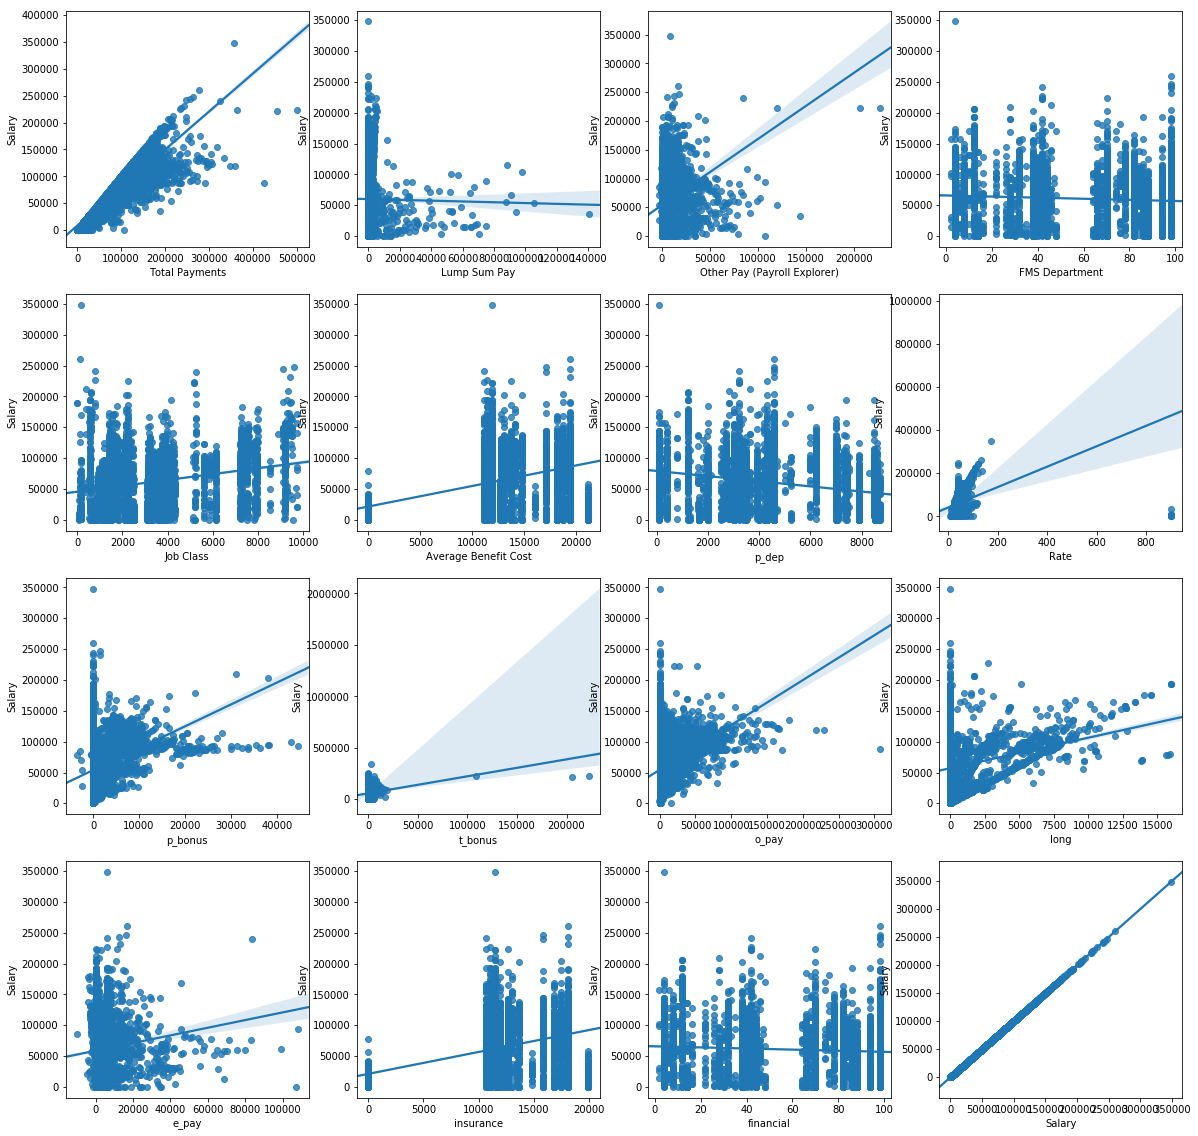

In [4]:
# Draw scatterplot 
plt.figure(figsize=(20,20))
for i in range(1,17):
    plt.subplot(4,4,i)
    sns.regplot(x=df_sample[cols[i-1]], y=df_sample["Salary"])

In [5]:
# onehot encoding
categotical_features = ["e_type", "benefit", "Time", "p_grade"]
dummy_df = pd.get_dummies(df, columns=categotical_features)
column_name = [i for i in dummy_df.columns if i != "Salary"]+["Salary"]
dummy_df = dummy_df[column_name]


In [18]:
# Train test split
# Original Data
from sklearn.model_selection import train_test_split

X = dummy_df[dummy_df.columns[:-1]]
y = dummy_df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_test.to_pickle("X_test.pickle")
y_test.to_pickle("y_test.pickle")


In [7]:
# Train test split
# split the data by one cutoff point
cutoff = 100000
smaller_df = dummy_df.loc[dummy_df["Salary"] <= cutoff]
larger_df = dummy_df.loc[dummy_df["Salary"] > cutoff]
X_smaller = smaller_df[smaller_df.columns[:-1]]
y_smaller = smaller_df[smaller_df.columns[-1]]
X_larger = larger_df[smaller_df.columns[:-1]]
y_larger = larger_df[smaller_df.columns[-1]]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_smaller, y_smaller, test_size=0.3, random_state=0)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_larger, y_larger, test_size=0.3, random_state=0)

In [8]:
# Train test split
# Standardization

from sklearn.preprocessing import StandardScaler

dummy_cols =[i for i in dummy_df.columns if i not in num_cols and i != "Salary"]

stdsc = StandardScaler()
X_train_num_std = stdsc.fit_transform(X_train[num_cols])
X_train_num_std = pd.DataFrame(X_train_num_std,columns=num_cols)
X_train_std = pd.concat([X_train_num_std , X_train[dummy_cols].reset_index()], axis=1).set_index("index")

X_test_num_std = stdsc.transform(X_test[num_cols])
X_test_num_std = pd.DataFrame(X_test_num_std,columns=num_cols)

X_test_std = pd.concat([X_test_num_std , X_test[dummy_cols].reset_index()], axis=1).set_index("index")

stdsc2 = StandardScaler()
y_train_std = stdsc2.fit_transform(y_train.values.reshape(-1, 1))
y_test_std = stdsc2.transform(y_test.values.reshape(-1, 1))

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
def model_eval(model,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """PyML P477-480
    Plot residual plot , dots should be located around the 0 line, and have no pattern
    R_square should be close to 1
    MSE should be small
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('R^2 train: %.3f, test: %.3f' %(r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
    print("R2",model.score(X_train, y_train))
    print("R2 Adj",1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print('MSE train: %.3f, test: %.3f' %(mse_train, mse_test))
    print('Over fitting' if mse_train < mse_test else 'Under fitting')
    
    plt.figure(figsize=(10,10))
    plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    #plt.hlines(y=0, xmin=-10, xmax=350000,color='black', lw=2)
    plt.show()
    


R^2 train: 0.856, test: 0.852
R2 0.8559426238484691
R2 Adj 0.855940051303447
MSE train: 246744485.639, test: 256477722.873
Over fitting


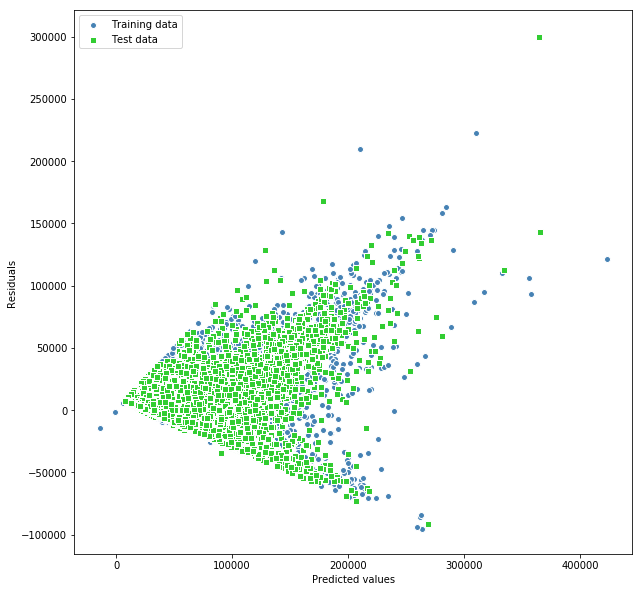

Wall time: 1.69 s


In [10]:
%%time
# Linear model with one feature

from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X_train["Total Payments"].values.reshape(-1,1),y_train)

model_eval(slr, X_test=X_test["Total Payments"].values.reshape(-1,1), X_train=X_train["Total Payments"].values.reshape(-1,1))

R^2 train: 1.000, test: 1.000
R2 0.9999995132452177
R2 Adj 0.9999995127405471
MSE train: 833.724, test: 756.527
Under fitting


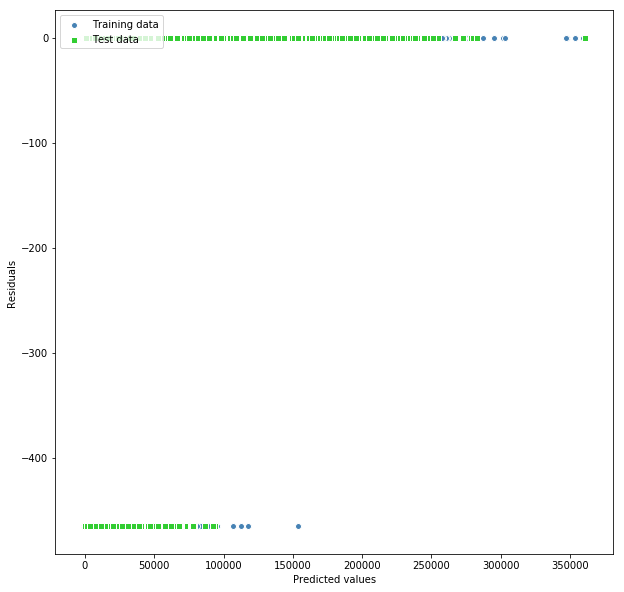

In [11]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50, loss='absolute_loss', residual_threshold=5.0, random_state=42)
ransac.fit(X_train, y_train)
model_eval(ransac)

R^2 train: 1.000, test: 1.000
R2 0.9999994417034443
R2 Adj 0.9999994410154049
MSE train: 595.743, test: 525.995
Under fitting


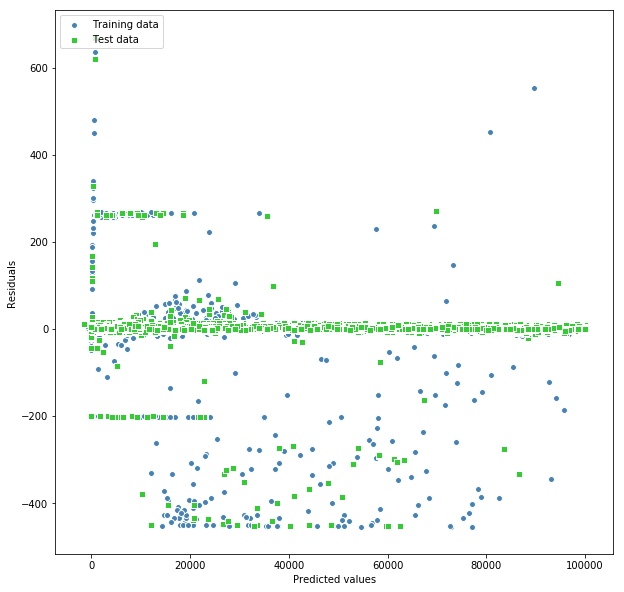

R^2 train: 1.000, test: 1.000
R2 0.9999999207695653
R2 Adj 0.9999999202484308
MSE train: 47.416, test: 56.058
Over fitting


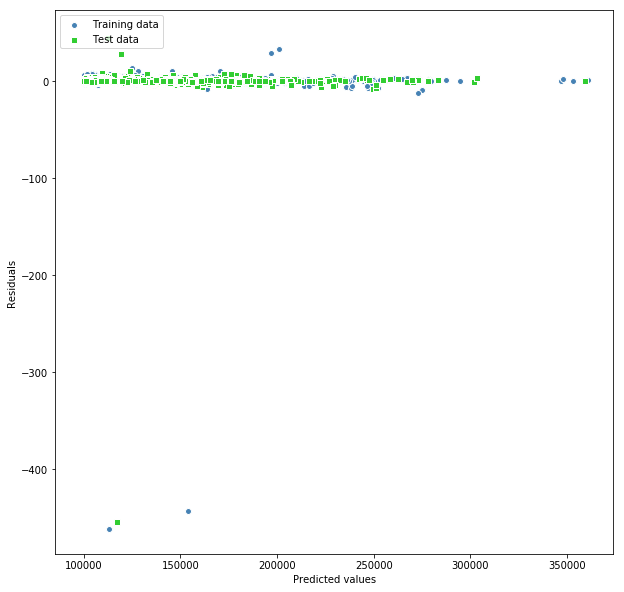

Wall time: 2.08 s


In [12]:
%%time
# Linear model with splited larger-smaller parts

from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(Xs_train,ys_train)

model_eval(slr,X_train=Xs_train, y_train=ys_train, X_test=Xs_test, y_test=ys_test)

from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(Xl_train,yl_train)

model_eval(slr,X_train=Xl_train, y_train=yl_train, X_test=Xl_test, y_test=yl_test)

R^2 train: 1.000, test: 1.000
R2 0.9999996008716474
R2 Adj 0.9999996007647075
MSE train: 683.635, test: 566.737
Under fitting


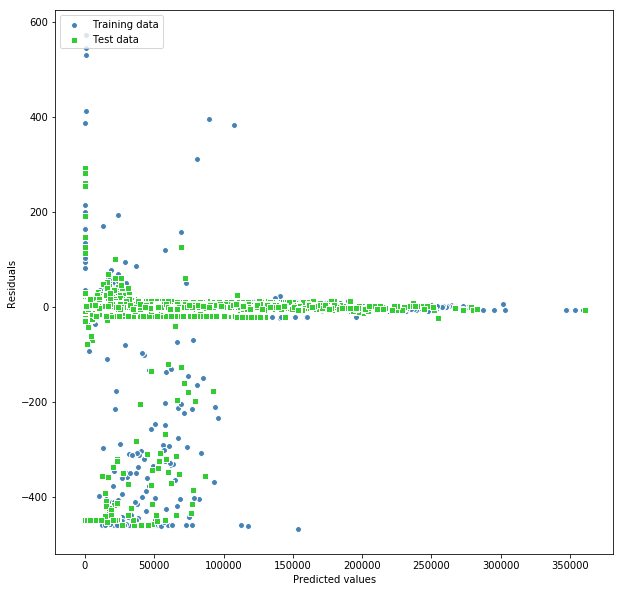

Wall time: 1.62 s


In [13]:
%%time
# Linear model with standardized data

from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X_train_num_std,y_train)

model_eval(slr, X_train=X_train_num_std, X_test=X_test_num_std, y_train=y_train, y_test=y_test)

# I don't know what's wrong with this part...

R^2 train: 1.000, test: 1.000
R2 0.9999997020137475
R2 Adj 0.9999997017047935
MSE train: 510.397, test: 466.703
Under fitting


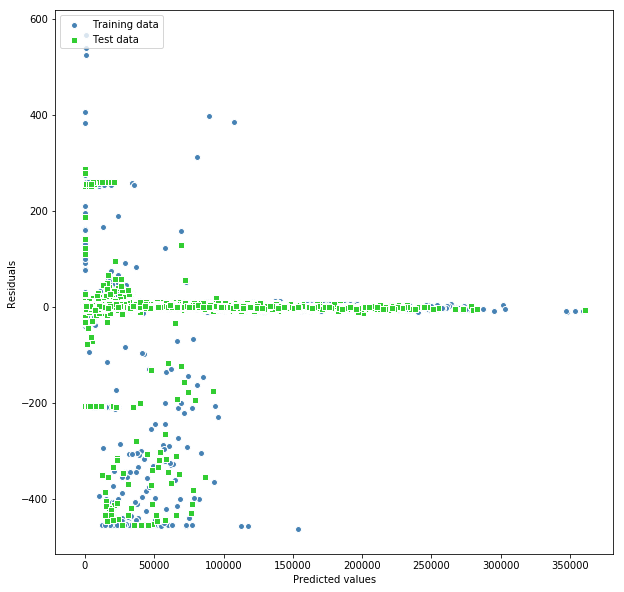

Wall time: 1.88 s


In [14]:
%%time
# Linear model

from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X_train,y_train)

model_eval(slr)


Ridge
R^2 train: 1.000, test: 1.000
R2 0.999999701986679
R2 Adj 0.9999997016776968
MSE train: 510.443, test: 466.422
Under fitting


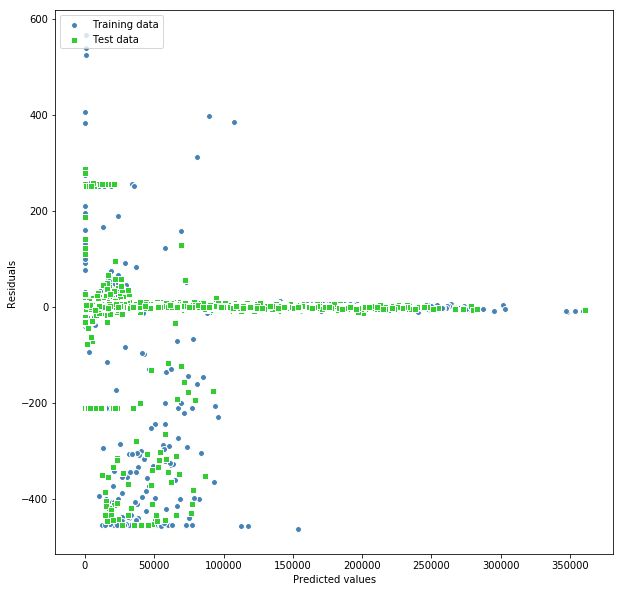

Lasso
R^2 train: 1.000, test: 1.000
R2 0.9999987066534188
R2 Adj 0.9999987053124685
MSE train: 2215.271, test: 2125.770
Under fitting


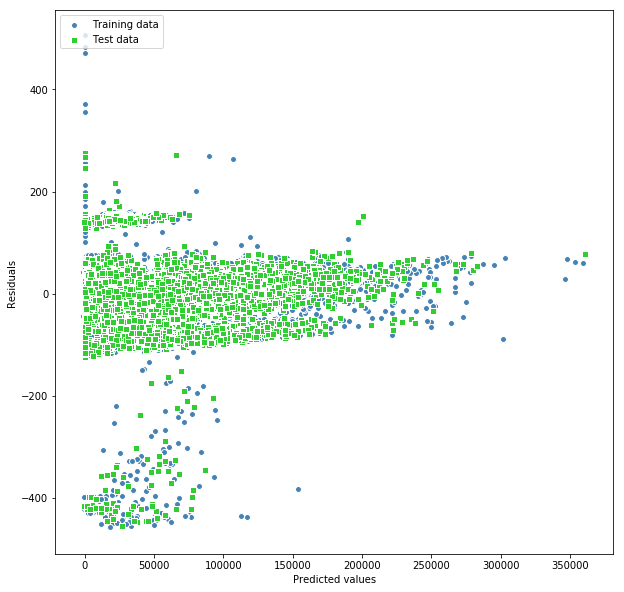

ElasticNet
R^2 train: 1.000, test: 1.000
R2 0.9999951321862438
R2 Adj 0.9999951271392622
MSE train: 8337.693, test: 8395.303
Over fitting


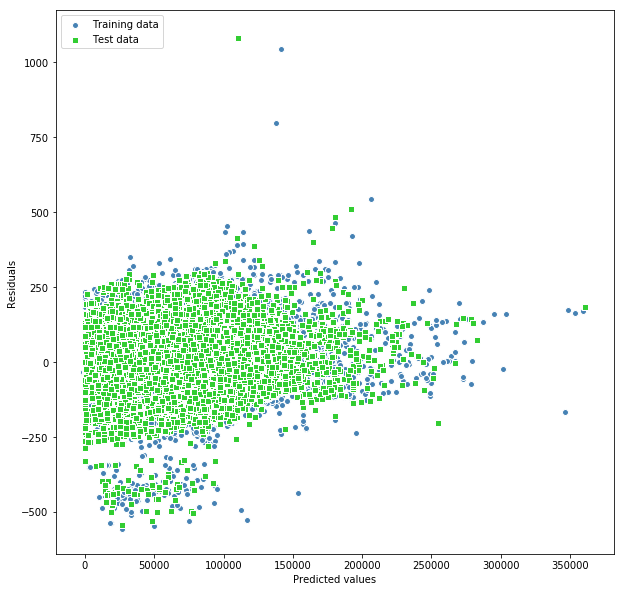

In [15]:
# Regularized Methods(Ridge, Least Absolute Shrinkage and Selection Operator (LASSO), Elastic Net)
print("Ridge")
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
model_eval(ridge)

print("Lasso")
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
model_eval(lasso)

print("ElasticNet")
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)
elanet.fit(X_train, y_train)
model_eval(elanet)

R^2 train: 0.948, test: 0.948
R2 0.9483370408934378
R2 Adj 0.9482834763946234
MSE train: 88489396.460, test: 90093448.216
Over fitting


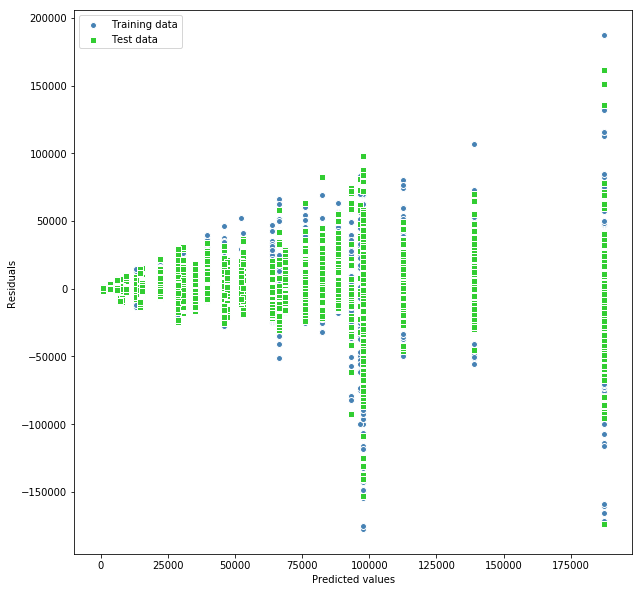

In [16]:
# Decision Tree Regression and Random forest Regression

# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)
model_eval(tree)

R^2 train: 0.999, test: 0.995
R2 0.9994693554442313
R2 Adj 0.9994688052684347
MSE train: 908899.089, test: 8648764.551
Over fitting


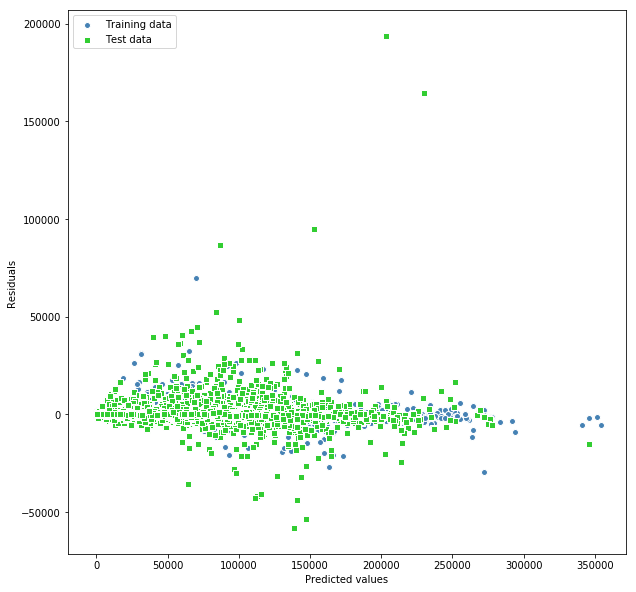

Wall time: 43.6 s


In [17]:
%%time
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, max_depth=None,criterion = 'mse', random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)
model_eval(forest)